<a href="https://colab.research.google.com/github/YaZlob/ML_project/blob/master/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В рамках зачета по предмету Введение в ИИ получено задание с соревнований на Kaggle: https://www.kaggle.com/lantian773030/pokemonclassification

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
!unzip -q /content/gdrive/MyDrive/archive.zip -d Pokemons

In [ ]:
ls

gdrive/  Pokemons/  sample_data/


In [ ]:
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
import random 
import PIL

from matplotlib import colors, pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from torchvision import models
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed(42)


cuda


Кодируем имя покемона цифрой

In [ ]:
images_path = "/content/Pokemons/PokemonData"
label_list = os.listdir(images_path)
Lencoder = LabelEncoder()
Lencoder.fit_transform(label_list)
Lencoder.classes_

array(['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok',
       'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise',
       'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard',
       'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster',
       'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo',
       'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee',
       'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor',
       'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude',
       'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler',
       'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan',
       'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon',
       'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan',
       'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp',
       'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton',
     

Демонстрация

In [ ]:
Lencoder.transform(["Abra","Aerodactyl","Alakazam","Zubat"])

array([  0,   1,   2, 149])

Посмотрим на данные

In [ ]:
total_image = 0
count = []
for pocemon_type in label_list:
    im_count = len(os.listdir(os.path.join(images_path,pocemon_type)))
    print(f"{pocemon_type}:{im_count}")
    count.append(im_count)
    total_image+= im_count
print("total images",total_image)

Jolteon:51
Staryu:47
Dodrio:39
Sandslash:45
Sandshrew:46
Exeggcute:46
Charmander:51
Nidorino:51
Abra:35
Diglett:39
Graveler:40
Eevee:37
MrMime:45
Bellsprout:40
Mewtwo:54
Magikarp:44
Rhydon:50
Nidoking:52
Victreebel:49
Meowth:26
Pidgeot:43
Rattata:43
Growlithe:44
Omanyte:45
Onix:42
Pidgeotto:40
Kakuna:47
Geodude:35
Beedrill:34
Gastly:44
Hitmonchan:47
Dragonite:48
Goldeen:47
Seaking:46
Hypno:47
Primeape:51
Arbok:41
Slowpoke:41
Shellder:46
Grimer:44
Vulpix:50
Vileplume:56
Kabuto:49
Wartortle:48
Flareon:45
Weezing:50
Kangaskhan:51
Pikachu:62
Dugtrio:51
Ivysaur:40
Raichu:51
Cloyster:49
Arcanine:41
Horsea:54
Metapod:53
Omastar:44
Tentacool:45
Gengar:49
Machamp:53
Alakazam:26
Farfetchd:48
Nidoqueen:52
Doduo:35
Lickitung:48
Machop:41
Ninetales:44
Ekans:36
Charizard:35
Electrode:51
Poliwhirl:50
Zapdos:52
Poliwrath:31
Hitmonlee:48
Vaporeon:59
Persian:37
Koffing:48
Haunter:48
Tauros:54
Magmar:44
Tangela:53
Aerodactyl:35
Krabby:48
Kadabra:49
Squirtle:52
Kabutops:42
Magnemite:46
Fearow:48
Golem:46


 Для упрощения восприятия данных, визуализируем количество покемонов каждого типа в виде гистограммы. Из нее мы видим, что большая часть покемонов содержит от 40 до 50 изображений,

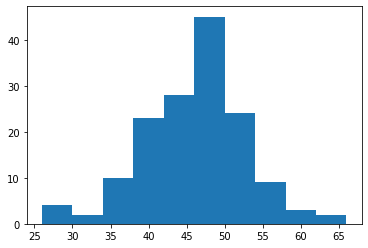

In [ ]:
n, bin, patches = plt.hist(count, bins=10)
plt.show()

Большинство изображений сосредоточено в районе 40-50 изображений, но есть и покемоны с 26 изображениями.

Нужно разделить датасет на 3 части: Тренировочную, Тестовую, Валидационную. Поскольку датасет не очень большой, то целесообразно разделить в пропорции 60:20:20, соответсвенно

In [ ]:
def create_dataset(images_path:str,label_encoder)->list:
    _ = []
    for pocemon in os.listdir(images_path):
        label = int(label_encoder.transform([pocemon])[0])
        pocemons_path = os.path.join(images_path,pocemon)
        for image in os.listdir(pocemons_path):
            if not image.endswith(".svg"):
                image = Image.open(os.path.join(pocemons_path,image))
                #image = image.resize((256,256))
                if image.mode == "RGB":
                    _.append([image,label])
    return _

dataset = create_dataset(images_path,Lencoder)

Посмотрим на покемонов

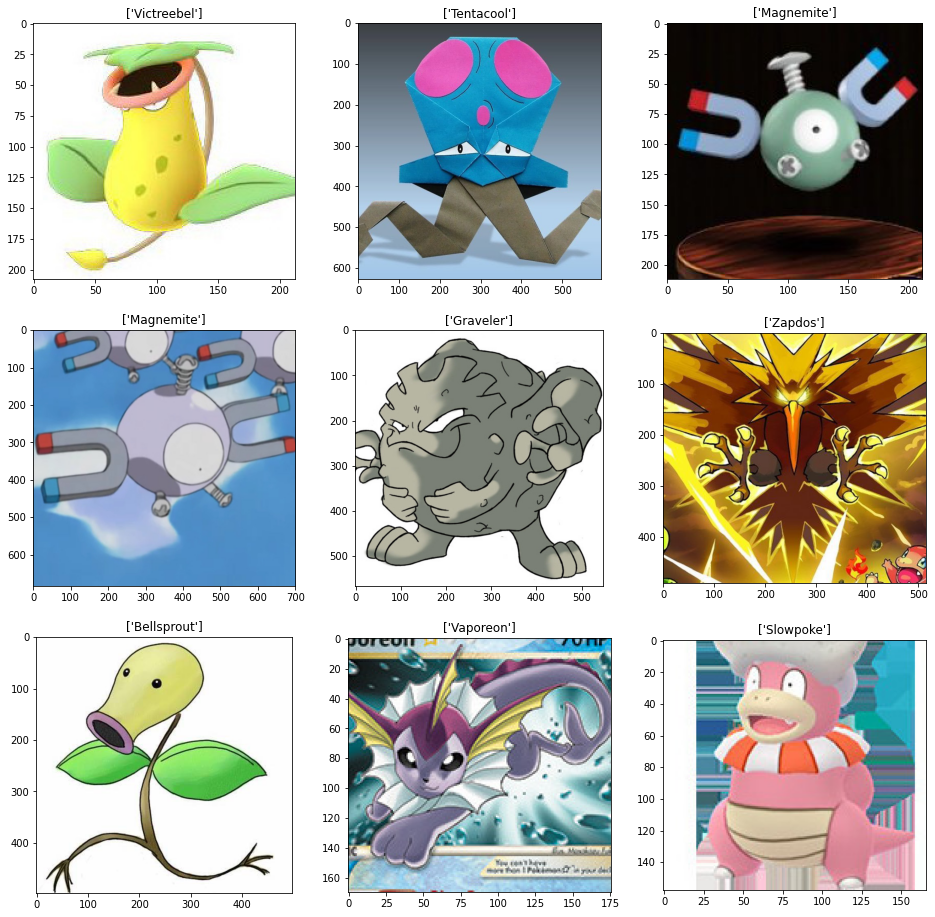

In [ ]:
def show_image(im_list,label_encoder):
  n_images = 9
  random_index = np.random.randint(low = 0,high = len(im_list), size = 9)
  fig = plt.figure(figsize=(16,16))
  for i in range(n_images):
    a = fig.add_subplot(3, 3, i + 1)
    image, label = im_list[random_index[i]]
    plt.imshow(image)
    a.set_title(label_encoder.inverse_transform([label]))
  plt.show()
show_image(dataset,Lencoder)

In [ ]:
train_dataset, val_test_dataset = train_test_split(dataset, test_size = 0.40, shuffle =True,random_state=42)
val_dataset, test_dataset = train_test_split(val_test_dataset, test_size = 0.5, shuffle =True,random_state=42)
print(f"Размер тренировочного датасета {len(train_dataset)} изображений")
print(f"Размер валидационного датасета {len(val_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")

Размер тренировочного датасета 4027 изображений
Размер валидационного датасета 1343 изображений
Размер тестового датасета 1343 изображений


Аугментация данных

In [ ]:
test_val_transform = transforms.Compose([transforms.Resize(size = (256,256)),
                                         transforms.ToTensor(),
                                         
                                         ])

train_transform = transforms.Compose([
                                      transforms.Resize(size = (256,256)), 
                                      transforms.RandomPerspective(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomGrayscale(),
                                      transforms.ToTensor(),
                                                                         
])

for i in range(len(train_dataset)):
    train_dataset[i][0] = train_transform(train_dataset[i][0])
for i in range(len(val_dataset)):
    val_dataset[i][0] = test_val_transform(val_dataset[i][0])
for i in range(len(test_dataset)):
    test_dataset[i][0] = test_val_transform(test_dataset[i][0])

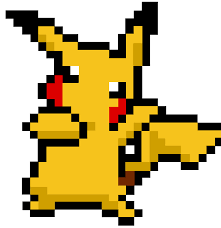

In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size = 64,
                          num_workers = 2)
val_loader = DataLoader( val_dataset,
                         batch_size = 32,
                         num_workers = 2)
test_loader = DataLoader(test_dataset,
                         batch_size = 32,
                         num_workers = 2)

In [ ]:
model = models.vgg19(pretrained=True)
model.fc = nn.Linear(1000,150)

In [ ]:
from torchsummary import summary
summary(model.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train_mode(model, criterion, optim, loader):
  train_loss, train_acc, processed_data = 0, 0, 0
  model.train()

  for image, label in loader:
      image, label = image.to(device), label.to(device)
      optim.zero_grad()
      pred = model(image)

      loss = criterion(pred,label)
      loss.backward()
      optim.step()

      predict = torch.argmax(pred,1)
      train_loss += loss.item() * image.size(0)
      processed_data += image.size(0)
      train_acc += (predict == label).sum()
  return (train_loss/float(processed_data), train_acc/float(processed_data))

def test_mode(model, criterion, loader):
  test_loss, test_acc, processed_data = 0, 0, 0
  model.eval()
  best_loss = 100
  for image, label in loader:
    image, label = image.to(device), label.to(device)
    with torch.set_grad_enabled(False):
        pred = model(image)
        loss = criterion(pred,label)
        predict = torch.argmax(pred,1)
    processed_data += image.size(0)
    test_loss += loss.item()
    test_acc += (predict == label).sum()
    
  return (test_loss/float(processed_data), test_acc/float(processed_data))

def loop(model, criterion, optim, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in tqdm_notebook(range(num_epochs)):
      train_loss, train_acc = train_mode(model, criterion, optim, train_loader)
      test_loss, test_acc = test_mode(model, criterion, test_loader)
      hist.append([train_loss, test_loss, train_acc, test_acc])
      print("train acc: {:.2f} | test acc: {:.2f}".format(train_acc, test_acc))
    
  return hist

def model_accuraccy(model,data_loader):
  acc, processed_data = 0, 0
  for image, label in data_loader:
      image, label = image.to(device), label.to(device)
      pred = model(image)
      predict = torch.argmax(pred,1)
      acc += (predict == label).sum()
      processed_data += image.size(0)
  return acc/float(processed_data)

Если lr = 0.0003, то сеть не будет обучаться. Совсем. Я потратил несколько дней на подборку гиперпараметров08

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()
history = loop(model.to(device), loss_fn, optimizer,train_loader, val_loader,15)
train_loss, test_loss, train_acc, test_acc = zip(*history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


train acc: 0.01 | test acc: 0.02
train acc: 0.02 | test acc: 0.03
train acc: 0.06 | test acc: 0.10
train acc: 0.13 | test acc: 0.18
train acc: 0.25 | test acc: 0.28
train acc: 0.43 | test acc: 0.40
train acc: 0.58 | test acc: 0.49
train acc: 0.67 | test acc: 0.45
train acc: 0.75 | test acc: 0.51
train acc: 0.84 | test acc: 0.59
train acc: 0.87 | test acc: 0.56
train acc: 0.92 | test acc: 0.61
train acc: 0.95 | test acc: 0.62
train acc: 0.95 | test acc: 0.63
train acc: 0.96 | test acc: 0.61



In [ ]:
def show_graph(l1:list,l2:list,mode = None):
    """
    l1 - train data
    l2 - test data
    """
    plt.figure(figsize=(8,8))
    plt.plot(l1, label = f"train {mode}")
    plt.plot(l2, label = f"test {mode}")
    plt.legend(loc = "best")
    plt.xlabel("epochs")


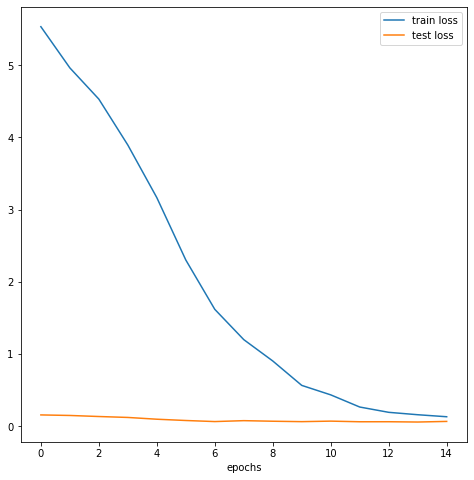

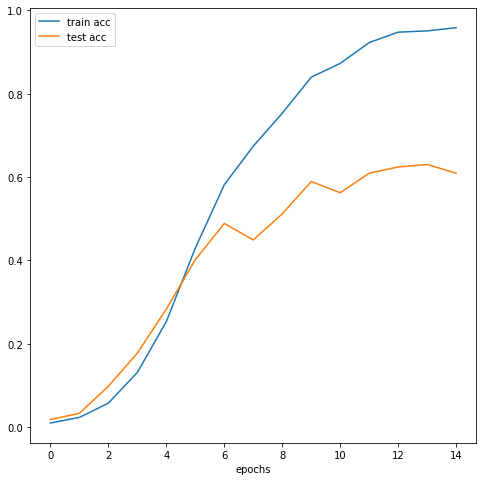

In [ ]:
show_graph(train_loss, test_loss, "loss")
show_graph(train_acc, test_acc, "acc")


Попробуем увеличить точность модели

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
history = loop(model.to(device), loss_fn, optimizer,train_loader, val_loader,7)
train_loss, test_loss, train_acc, test_acc = zip(*history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


train acc: 0.99 | test acc: 0.69
train acc: 1.00 | test acc: 0.70
train acc: 1.00 | test acc: 0.70
train acc: 1.00 | test acc: 0.71
train acc: 1.00 | test acc: 0.70
train acc: 1.00 | test acc: 0.71
train acc: 1.00 | test acc: 0.71



In [ ]:
accuracy = 100* model_accuraccy(model, val_loader)
print(f"Точность нейронной сети :{accuracy}%")

Точность нейронной сети :71.40730285644531%


In [ ]:
def inverse_transform(image:torch.Tensor, mean :list, std:list):
  image = transforms.ToPILImage(mode='RGB')(image)
  return image

In [ ]:
def show_predict(model,loader,label_encoder):
  model.cpu()
  num_image = 9
  fig = plt.figure(figsize=(16,16))
  random_index = np.random.randint(0, len(test_dataset),size=9)
  for i in range(num_image):
    # part of predict neural network
    a = fig.add_subplot(3, 3, i + 1)
    image, _ = loader.dataset[random_index[i]]
    image_for_graph = copy.deepcopy(image)
    image = image.unsqueeze(0)
    pred = model(image)
    predict = pred.argmax(1)
    # part of visualization
    image_for_graph = inverse_transform(image_for_graph,[0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    plt.imshow(image_for_graph)
    a.set_title(label_encoder.inverse_transform([predict.numpy()]))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


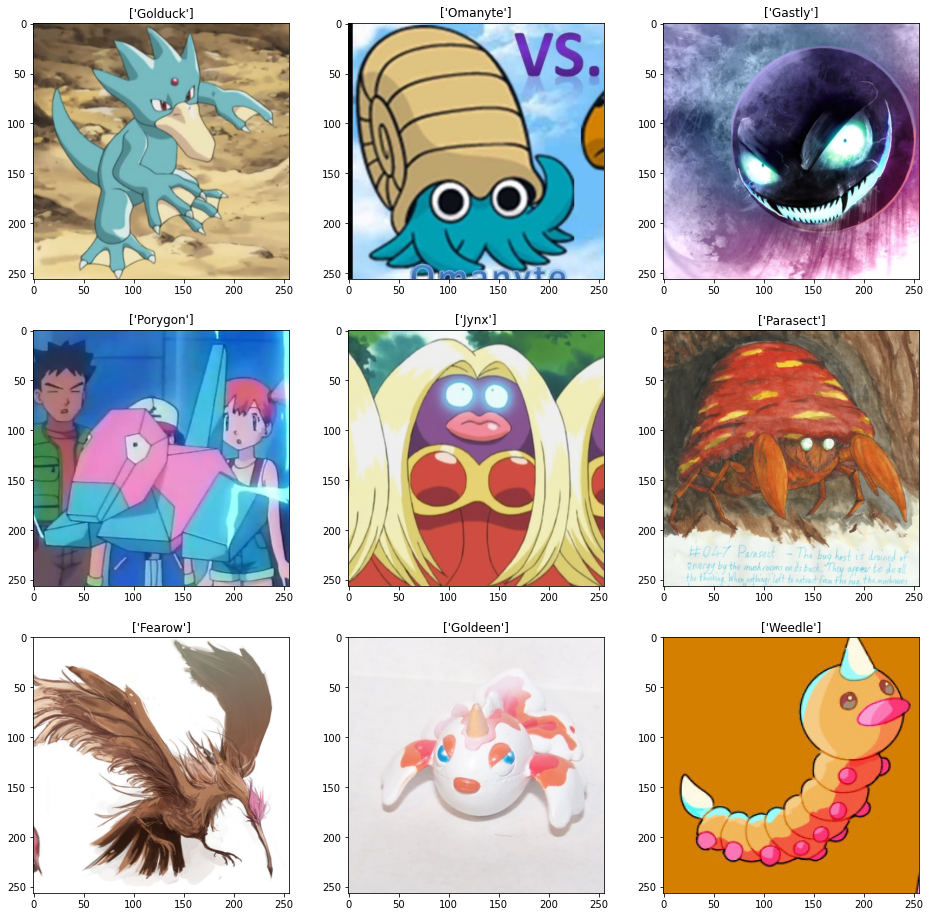

In [ ]:
show_predict(model,val_loader,Lencoder)

In [ ]:
torch.save(model.state_dict(),"VGG_pokemons.pth")

In [ ]:
ls

gdrive/  Pocemons/  sample_data/  VGG_pokemons.pth


Моя попытка улучшить точность. 

Идеи для улучшения:

1.   Увеличить количество изображений каждого покемона до какого-то N, искуственно разбить на 3 датасета, чтобы каждый покемон был представлен одинаковым количеством примеров в тренировочной, тестовой и валидационной выборке
2.   Так как искусственное увеличение количество изображений пораждает повторы, нужно расширить параметры аугментации
3.   Использовать Sheduler
4.   Так как мне нельзя использовать готовые сети, я бы хотел реализовать свою идею, но оказалось, что Гугл это сделал еще в 2017 году (François Chollet). Попробую реализовать свою версию.






Время реализовывать собственную сеть)

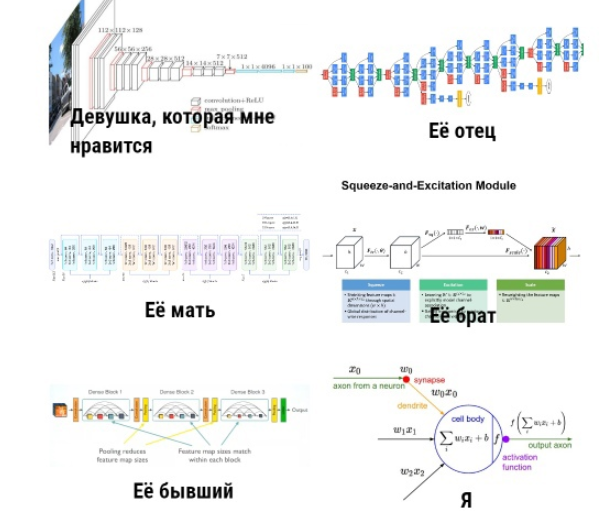

In [ ]:
class Create_Dataset():
    def __init__(self, images_path, label_encoder, N = 100):
        self.images_path = images_path
        self.label_encoder = label_encoder
        self.train_transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      transforms.Resize(size = (299,299)),
                                      transforms.RandomPerspective(0.1,0.1),
                                      transforms.RandomRotation(10),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
        
        self.test_val_transform = transforms.Compose([
                                         transforms.ToPILImage(),
                                         transforms.Resize(size = (299,299)),
                                         transforms.ToTensor()])

        self.N = N # to increase dataset

    def upload_images(self,path,pocemon):
        _ = []
        for image in os.listdir(path):
            label = int(self.label_encoder.transform([pocemon])[0])
            image_path = os.path.join(path,image)
            if not image.endswith(".svg"):
                image = Image.open(image_path)
                if image.mode == "RGB" and image.size[0] > 256:
                    _.append([np.array(image),label])
        return _

    def increase_data(self,path,pocemon):

        images = self.upload_images(path,pocemon)
        im_count = len(images)
        new_im_count = self.N - im_count
        new_im_index = np.random.randint(low = 0, high = im_count,size = new_im_count)
        for index in new_im_index:
            images.append(images[index])
        return images

    def image_augm(self,images, mode):
        augm = self.test_val_transform
        if mode == "train":
            print(mode)
            augm = self.train_transform

        for i in range(len(images)):
              images[i][0] = augm(images[i][0])

        return images


    def create_datasets(self):
        _ = []
        
        for pocemon in os.listdir(self.images_path):
            print(pocemon)
            path = os.path.join(self.images_path,pocemon)
            pocemon_images = self.increase_data(path,pocemon)
            _ = _ + pocemon_images
        return _

data = Create_Dataset(images_path,Lencoder)
dataset = data.create_datasets()

Jolteon
Staryu
Dodrio
Sandslash
Sandshrew
Exeggcute
Charmander
Nidorino
Abra
Diglett
Graveler
Eevee
MrMime
Bellsprout
Mewtwo
Magikarp
Rhydon
Nidoking
Victreebel
Meowth
Pidgeot
Rattata
Growlithe
Omanyte
Onix
Pidgeotto
Kakuna
Geodude
Beedrill
Gastly
Hitmonchan
Dragonite
Goldeen
Seaking
Hypno
Primeape
Arbok
Slowpoke
Shellder
Grimer
Vulpix
Vileplume
Kabuto
Wartortle
Flareon
Weezing
Kangaskhan
Pikachu
Dugtrio
Ivysaur
Raichu
Cloyster
Arcanine
Horsea
Metapod
Omastar
Tentacool
Gengar
Machamp
Alakazam
Farfetchd
Nidoqueen
Doduo
Lickitung
Machop
Ninetales
Ekans
Charizard
Electrode
Poliwhirl
Zapdos
Poliwrath
Hitmonlee
Vaporeon
Persian
Koffing
Haunter
Tauros
Magmar
Tangela
Aerodactyl
Krabby
Kadabra
Squirtle
Kabutops
Magnemite
Fearow
Golem
Snorlax
Jigglypuff
Weepinbell
Seadra
Clefairy
Wigglytuff
Spearow
Rhyhorn
Butterfree
Electabuzz
Scyther
Muk
Ponyta
Pidgey
Slowbro
Alolan Sandslash
Lapras
Kingler
Rapidash
Venonat
Mew
Charmeleon
Voltorb
Venomoth
Raticate
Caterpie
Tentacruel
Dewgong
Psyduck
Dragonair

In [ ]:
train_dataset, val_test_dataset = train_test_split(dataset, test_size = 0.40, shuffle =True,random_state=42)
val_dataset, test_dataset = train_test_split(val_test_dataset, test_size = 0.5, shuffle =True,random_state=42)
print(f"Размер тренировочного датасета {len(train_dataset)} изображений")
print(f"Размер валидационного датасета {len(val_dataset)} изображений")
print(f"Размер тестового датасета {len(test_dataset)} изображений")

Размер тренировочного датасета 9000 изображений
Размер валидационного датасета 3000 изображений
Размер тестового датасета 3000 изображений


In [ ]:
train_loader = DataLoader(data.image_augm(train_dataset,mode = "train"),
                          batch_size = 64,
                          num_workers = 2)
val_loader = DataLoader(data.image_augm(val_dataset,mode = "val"),
                         batch_size = 32,
                         num_workers = 2)
test_loader = DataLoader(data.image_augm(test_dataset,mode = "test"),
                         batch_size = 32,
                         num_workers = 2)

train


In [ ]:
def show_tensor_image(loader,label_encoder):
  num_image = 9
  fig = plt.figure(figsize=(10,10))
  random_index = np.random.randint(0, len(loader),size=9)
  for i in range(num_image):
    a = fig.add_subplot(3, 3, i + 1)
    image, _ = loader.dataset[random_index[i]]
    image = transforms.ToPILImage(mode='RGB')(image)
    plt.imshow(image)
    a.set_title(label_encoder.inverse_transform([_]))

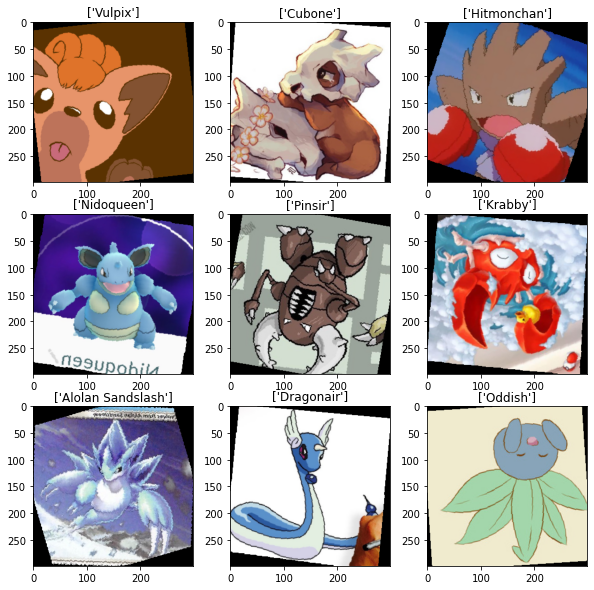

In [ ]:
show_tensor_image(val_loader,Lencoder)

Сама идея сети:



In [ ]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        # stage 1
        self.conv_layer1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels = 64, kernel_size=7, stride = 2, padding=3),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=3,stride=2)) 
    
    def _convblock(self,x,in_channels, out_channels, kernel_size = 3, padding = 1, stride = 2):

         pool_part = nn.MaxPool2d(kernel_size = kernel_size, padding = padding, stride = stride)
         conv_pool_part = nn.Sequential(
             nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=3, padding = padding, stride = stride)
         )
         conv_part =  nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, padding = padding, stride=stride)
         pool = pool_part(x)
         convpool = conv_pool_part(x)
         conv = conv_part(x)
         x = torch.cat([pool,convpool,conv], dim = 1)
         final_layer = nn.Sequential(
             nn.BatchNorm2d(x.shape[1]),
             nn.ReLU(),
         )

         return final_layer(x)


    def forward(self,x):
      x = x.cpu()
      x = self.conv_layer1(x)
      x = self._convblock(x,64,128)
      x = self._convblock(x,in_channels = x.shape[1], out_channels = 256)
      x = self._convblock(x,in_channels = x.shape[1], out_channels = 512)
      x = self._convblock(x,in_channels = x.shape[1], out_channels = 512)
      x = x.view(x.size(0), -1)
      last_layer = nn.Sequential(
          nn.Linear(in_features = 1856* 8* 8, out_features = 16000),
          nn.BatchNorm1d(16000),
          nn.Dropout(0.3),
          nn.ReLU(),

          nn.Linear(in_features = 16000, out_features=4000),
          nn.BatchNorm1d(4000),
          nn.Dropout(0.3),
          nn.ReLU(),

          nn.Linear(in_features = 4000, out_features = len(label_list))
      )
      return last_layer(x)

model = NN()

Вывод по работе сети. Идея - соединить LeNet & ResNet. Гипотетически сеть должна работать, но объема памяти, которую выделяет Google недостаточно, это приводит к экстренному прекращению сеанса. Далее, читая статьи, оказалось, что эта идея не нова и была реализована в 2017 году Франсуа Шолле.

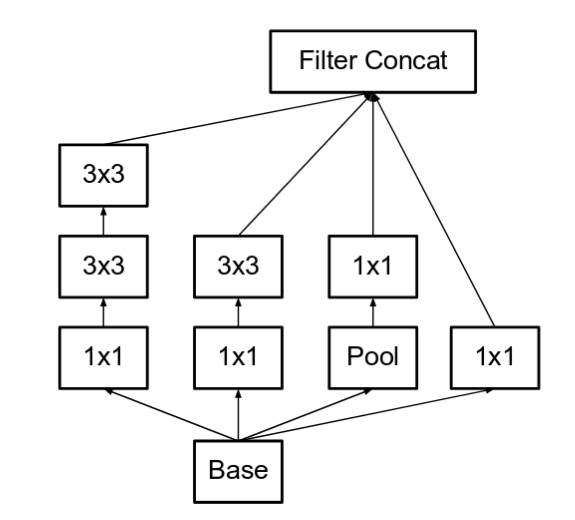

Свертки 1х1 реализованы для уменьшения размерности тензора, именно этого не хватало в моей сети.

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
for i,param in enumerate(inception.parameters()):
    print(param.requires_grad)

In [ ]:
inception.AuxLogits.fc = nn.Linear(768, 150)
inception.fc = nn.Linear(2048, 150)

In [ ]:
from torchsummary import summary
summary(inception.cuda(), (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Теперь нужно добавить Sheduler, который будет уменьшать lr на i-ой эпохе

Оптимайзер, функцию потерь оставим прежней

In [ ]:
from torch.optim import lr_scheduler

In [ ]:
optimizer = optim.Adam(inception.parameters(), lr = 0.0001)
loss_fn = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
def train_mode(model, criterion, optim, loader):
  train_loss, train_acc, processed_data = 0, 0, 0
  model.train()

  for image, label in loader:
      image, label = image.to(device), label.to(device)
      optim.zero_grad()

      outputs, aux_outputs = model(image)
      loss1 = criterion(outputs, label)
      loss2 = criterion(aux_outputs, label)
      loss = loss1 + 0.4*loss2

      loss.backward()
      optim.step()

      predict = torch.argmax(outputs,1)
      train_loss += loss.item() * image.size(0)
      processed_data += image.size(0)
      train_acc += (predict == label).sum()
  return (train_loss/float(processed_data), train_acc/float(processed_data))

def test_mode(model, criterion, loader):
  test_loss, test_acc, processed_data = 0, 0, 0
  model.eval()
  best_loss = 100
  for image, label in loader:
    image, label = image.to(device), label.to(device)
    with torch.set_grad_enabled(False):
      
        outputs = model(image)
        loss = criterion(outputs,label)

        predict = torch.argmax(outputs,1)
    processed_data += image.size(0)
    test_loss += loss.item()
    test_acc += (predict == label).sum()
    
  return (test_loss/float(processed_data), test_acc/float(processed_data))

def shed_loop(model, criterion, optim,scheduler, train_loader, test_loader, num_epochs):
  hist = []
  for epoch in tqdm_notebook(range(num_epochs)):
      train_loss, train_acc = train_mode(model, criterion, optim, train_loader)
      test_loss, test_acc = test_mode(model, criterion, test_loader)
      hist.append([train_loss, test_loss, train_acc, test_acc])
      scheduler.step()
      print("train acc: {:.2f} | test acc: {:.2f}".format(train_acc, test_acc))
    
  return hist


In [ ]:
hist = shed_loop(model = inception.to(device),
                 criterion = loss_fn,
                 optim = optimizer,
                 scheduler = exp_lr_scheduler,
                 train_loader = train_loader,
                 test_loader = test_loader,
                 num_epochs = 40)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


train acc: 0.42 | test acc: 0.83
train acc: 0.93 | test acc: 0.97
train acc: 0.99 | test acc: 0.98
train acc: 1.00 | test acc: 0.98
train acc: 1.00 | test acc: 0.98
train acc: 1.00 | test acc: 0.98
train acc: 1.00 | test acc: 0.98
train acc: 1.00 | test acc: 0.98
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc: 1.00 | test acc: 0.99
train acc:

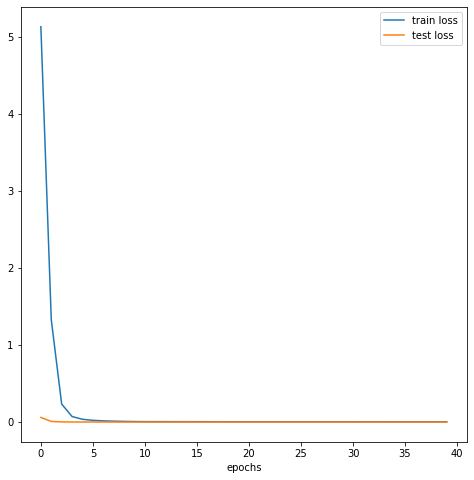

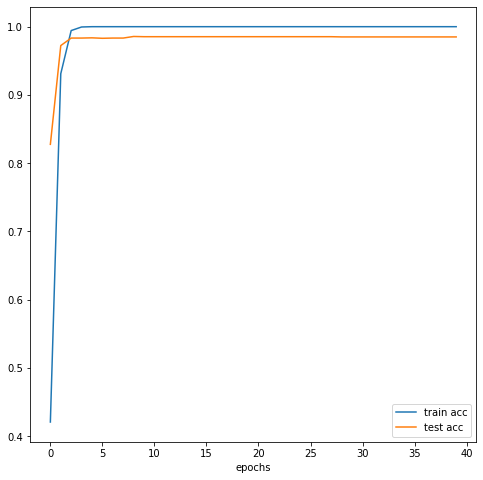

In [ ]:
train_loss, test_loss, train_acc, test_acc = zip(*hist)
show_graph(train_loss, test_loss, "loss")
show_graph(train_acc, test_acc, "acc")

In [ ]:
torch.save(inception.state_dict(),"Inception_pokemons.pth")

In [ ]:
inception.load_state_dict(torch.load("/content/Inception_pokemons.pth"))
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
accuracy = 100* model_accuraccy(inception.to(device), val_loader)
print(f"Точность нейронной сети :{accuracy}%")

Точность нейронной сети :98.5%


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


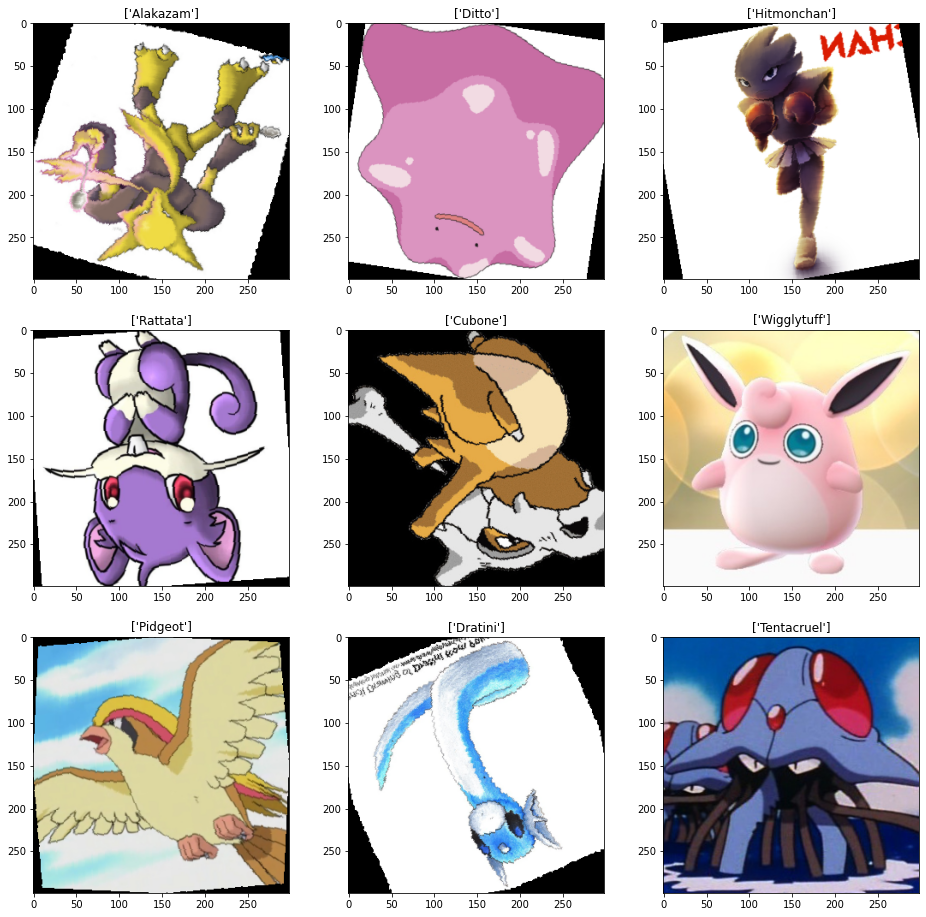

In [ ]:
show_predict(inception,val_loader,Lencoder)